# Aumento de precios de cartera

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from datetime import datetime
from dateutil.relativedelta import relativedelta
import numpy as np
import pyodbc as odbc
sys.path.append(r"C:\Users\mariajose_chinchilla\Documents\GitHub\proyectos_varios\codigos")
from utils import calcular_cuota, ingresos_financieros, ingreso_fin_entre_fechas, meses_entre_fechas

In [2]:
aumento_ensayo = 12
clientes = pd.read_feather("../db/Clientes_aumento_fecha.feather")
clientes = clientes[clientes["Tasa"] < 17]
clientes["Tasa_inicial"] = clientes["Tasa"]
clientes["Tasa"] = clientes["Tasa"] + 1
salarios = pd.read_csv(r"C:\Users\mariajose_chinchilla\Desktop\Pasados\Noviembre\db\cartera 2.csv")


clientes = pd.merge(clientes, salarios, on="NoCredito", how="left", suffixes=("", "_or"))
clientes["CUMPLE 15"] = np.where(clientes["SaldoCapital_or"] / clientes["MontoDesembolsado"] > 0.85, 0 , 1)


clientes.head(3)

C:\Users\mariajose_chinchilla\AppData\Local\Temp\ipykernel_17276\53211037.py:6: DtypeWarning: Columns (43,45,46,61,63,68) have mixed types. Specify dtype option on import or set low_memory=False.
  salarios = pd.read_csv(r"C:\Users\mariajose_chinchilla\Desktop\Pasados\Noviembre\db\cartera 2.csv")


,DPI,NoCredito,MontoDesembolsado,SaldoCapital,Plazo,Tasa,CuotaCredito,Cuota final,Tasa final,ingreso financiero original,...,ScoreRevolving,ScoreRevolvingCat,NumeroPatrono,ReglonPresupuestario,MesProcesamiento,SaldoExterno,CategoriaExterna,DiasMoraExterna,MontoCargos,CUMPLE 15
0,2348353620101,12303492950,22000.0,14817.04,48,16.0,612.28,657.802601,19.0,1314,...,500.0,High,999999.0,0.0,202410.0,0.00,A,0.0,442.17,1
1,2172340540102,12309180762,32500.0,25626.68,48,17.0,921.06,988.986776,20.0,2635,...,357.0,VeryHigh,999999.0,0.0,202410.0,0.00,A,0.0,810.75,1
2,1908814610101,12307961645,27000.0,20320.77,48,17.0,765.19,821.619783,20.0,2043,...,446.0,VeryHigh,999999.0,0.0,202410.0,32014.28,A,0.0,638.61,1


In [3]:
# # Encontrar la fecha de desembolso para encontrar los meses transcurridos
# creditos = tuple(credito for credito in clientes["NoCredito"].unique().tolist())


# servidor = "BTBICC2-VM"
# base = "CARTERA_ASIGNACION"
# sql_conn = odbc.connect('Driver={SQL Server};'
#                         f'Server={servidor};'
#                         f'Database={base};'
#                         'Trusted_Connection=yes;')

# query = f"""SELECT 
#                 [NO_CREDITO] as NoCredito
#                 ,[FECHA_APERTURA] AS FechaDesembolso
#             FROM [CARTERA_ASIGNACION].[Crecimiento].[FACT_COSECHAS_CARTERA_FIDUCIARIA]
#             WHERE [NO_CREDITO] in {creditos}
#         """

# fechas = pd.read_sql(query, sql_conn)
# fechas["NoCredito"] = fechas["NoCredito"].astype("int64")
# clientes = pd.merge(clientes, fechas, on="NoCredito", how="inner")
# clientes.head(3)

In [4]:
# Tratamiento para RCI
clientes["RciInternoInicial"] = np.where(clientes["RciInternoInicial"] <= 4, clientes["RciInternoInicial"] * 100, clientes["RciInternoInicial"])
clientes["RciGlobalInicial"] = np.where(clientes["RciGlobalInicial"] <= 4, clientes["RciGlobalInicial"] * 100, clientes["RciGlobalInicial"])

Text(0.5, 1.0, 'Clientes con aumento según tipo de pago')

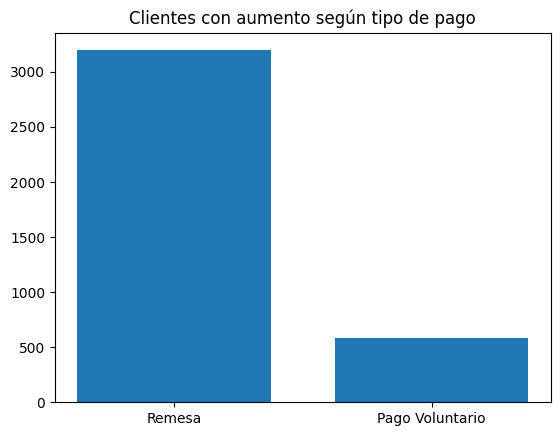

In [5]:
conteo_tipo_pago = clientes["Tipo_pago"].value_counts().reset_index(name="Clientes")
plt.bar(conteo_tipo_pago["Tipo_pago"], conteo_tipo_pago["Clientes"], width=0.75)
plt.title("Clientes con aumento según tipo de pago")

## Diseño de oferta

In [6]:
# Función para cálculo de denominador de la solución a la ecuación
def denominador_ensayo(tasa: float, plazo: int, meses_ensayo: int, 
                       es_cred_nuevo: int, cumple_15: int) -> float:
    p1 = 1 / (1 - (1 + tasa)**plazo)
    p2 = ((1 + tasa)**meses_ensayo - 1)
    p3 = 12 * tasa * (1 + tasa)**plazo / ((1 + tasa)**plazo - 1)
    
    if es_cred_nuevo == 1:
        denominador = (p1 * p2 + p3)
    elif es_cred_nuevo == 0:
        denominador = (p1 * p2 + p3 - (0.05*0.45) * (1 - cumple_15))
    
    return denominador



In [7]:
# Calcular el plazo transcurrido
clientes["FechaDesembolso"] = pd.to_datetime(clientes["FechaDesembolso"], errors="coerce", format="%Y-%m-%d")

clientes["PlazoTranscurrido"] = clientes.apply(lambda x: meses_entre_fechas(x["FechaDesembolso"],
                                                                            pd.to_datetime("2025-03-01")
                                                                            ),
                                                                            axis=1)

# Primero procedemos a calcular el ingreso que no estaríamos recibiendo por el aumento de tasa 

# Cálculo de cuál sería la nueva cuota del cliente
clientes["NUEVA_CUOTA"] = clientes.apply(lambda x: calcular_cuota(x["MontoDesembolsado"],
                                                                  x["Tasa final"]/1200,
                                                                  x["Plazo"]),
                                                                  axis=1)

# Ahora el ingreso financiero que se recibiría con la tasa aumetnada 
# en el crédito durante el plazo elegido para el ensayo
clientes["IF_V"] = clientes.apply(lambda x: ingreso_fin_entre_fechas(x["MontoDesembolsado"],
                                                                     x["Tasa final"]/1200,
                                                                     x["Plazo"],
                                                                     x["PlazoTranscurrido"],
                                                                     x["PlazoTranscurrido"] + aumento_ensayo),
                                                                     axis=1)

clientes["Tasa_cred_vigente"] = clientes["Tasa"]

clientes["Tasa"] = np.where(clientes["Tasa"] < 15, clientes["Tasa"] + 1, clientes["Tasa"])

clientes["DENOMINADOR_ENSAYO_NUEVO"] = clientes.apply(lambda x: denominador_ensayo((x["Tasa"])/1200,
                                                                   x["Plazo"],
                                                                   aumento_ensayo,
                                                                   1, x["CUMPLE 15"]),
                                                                   axis=1)

clientes["DENOMINADOR_ENSAYO_RECRED"] = clientes.apply(lambda x: denominador_ensayo(x["Tasa"]/1200,
                                                                   x["Plazo"],
                                                                   aumento_ensayo,
                                                                   0, x["CUMPLE 15"]),
                                                                   axis=1)

clientes["MONTO_OFERTA_NUEVO"] = clientes["IF_V"] / clientes["DENOMINADOR_ENSAYO_NUEVO"]
clientes["MONTO_OFERTA_RECRED"] = clientes["IF_V"] / clientes["DENOMINADOR_ENSAYO_RECRED"]

In [8]:
# Cálculo de imapcto de la iniciativa bajo la figura de un crédito nuevo
clientes["CUOTA_NUEVO_CREDITO"] = clientes.apply(lambda x: calcular_cuota(x["MONTO_OFERTA_NUEVO"],
                                                                          x["Tasa"]/1200,
                                                                          x["Plazo"]),
                                                                          axis=1)

# Calcular el ingreso financiero que traerá el cambio
clientes["INGRESO CREDITO NUEVO"] = clientes.apply(lambda x: ingresos_financieros(x["MONTO_OFERTA_NUEVO"],
                                                                                  x["Tasa"]/1200,
                                                                                  x["Plazo"],
                                                                                  aumento_ensayo), axis=1)


################### REPETIR PERO PARA EL RECRÉDITO ###########
clientes["CUOTA_RECRED_ENSAYO"] = clientes.apply(lambda x: calcular_cuota(x["MONTO_OFERTA_RECRED"],
                                                                          x["Tasa"]/1200,
                                                                          x["Plazo"]),
                                                                          axis=1)

# Calcular el ingreso financiero que traerá el cambio
clientes["INGRESO RECRED ENSAYO"] = clientes.apply(lambda x: ingresos_financieros(x["MONTO_OFERTA_RECRED"],
                                                                                  x["Tasa"]/1200,
                                                                                  x["Plazo"],
                                                                                  aumento_ensayo), axis=1)

clientes["INGRESO RECRED ENSAYO"] = clientes["INGRESO RECRED ENSAYO"] - (1 - clientes["CUMPLE 15"]) * 0.05*0.45*clientes["MONTO_OFERTA_RECRED"]

In [9]:
clientes.head(3)

,DPI,NoCredito,MontoDesembolsado,SaldoCapital,Plazo,Tasa,CuotaCredito,Cuota final,Tasa final,ingreso financiero original,...,DiasMoraExterna,MontoCargos,CUMPLE 15,Tasa_cred_vigente,DENOMINADOR_ENSAYO_NUEVO,DENOMINADOR_ENSAYO_RECRED,MONTO_OFERTA_NUEVO,MONTO_OFERTA_RECRED,CUOTA_RECRED_ENSAYO,INGRESO RECRED ENSAYO
0,2348353620101,12303492950,22000.0,14817.04,48,16.0,612.28,657.802601,19.0,1314,...,0.0,442.17,1,16.0,0.146189,0.146189,14188.785643,14188.785643,402.114169,2074.243790
1,2172340540102,12309180762,32500.0,25626.68,48,17.0,921.06,988.986776,20.0,2635,...,0.0,810.75,1,17.0,0.155597,0.155597,26151.576597,26151.576597,754.604849,4069.098700
2,1908814610101,12307961645,27000.0,20320.77,48,17.0,765.19,821.619783,20.0,2043,...,0.0,638.61,1,17.0,0.155597,0.155597,20326.378094,20326.378094,586.518500,3162.717107


## Evaluar si la oferta es viable por temas de RCI

In [10]:
clientes["NUEVO RCI INTERNO CN"] = clientes["RciInternoInicial"] + clientes["CUOTA_NUEVO_CREDITO"] / clientes["IngresosValidos"] * 100
clientes["NUEVO RCI GLOBAL CN"] = clientes["RciGlobalInicial"] + clientes["CUOTA_NUEVO_CREDITO"] / clientes["IngresosValidos"] * 100

### LO MISMO PERO PARA RECRÉDITO ####
clientes["NUEVO RCI INTERNO RECRED"] = clientes["RciInternoInicial"] + clientes["CUOTA_RECRED_ENSAYO"] / clientes["IngresosValidos"] * 100 - clientes["CuotaCredito"] / clientes["IngresosValidos"] * 100
clientes["NUEVO RCI GLOBAL RECRED"] = clientes["RciGlobalInicial"] + clientes["CUOTA_RECRED_ENSAYO"] / clientes["IngresosValidos"] * 100 - clientes["CuotaCredito"] / clientes["IngresosValidos"] * 100

In [11]:
clientes["VIABLE PARA VENTA"] = np.where(((clientes["NUEVO RCI INTERNO CN"] <= 50) | (clientes["NUEVO RCI INTERNO RECRED"] <= 50)), 1, 0)
print(f"El porcentaje de clientes a los que se les puede vender es {len(clientes[clientes["VIABLE PARA VENTA"] == 1]) / len(clientes)}")
print(clientes[clientes["VIABLE PARA VENTA"] == 1]["Tipo_pago"].value_counts())

El porcentaje de clientes a los que se les puede vender es 0.5587612493382742
Tipo_pago
Remesa             1542
Pago Voluntario     569
Name: count, dtype: int64


In [12]:
cols = ["MONTO_OFERTA_NUEVO", "MONTO_OFERTA_RECRED", "IF_V", "INGRESO CREDITO NUEVO", "INGRESO RECRED ENSAYO",
         "CUMPLE 15", "NUEVO RCI INTERNO CN", "NUEVO RCI INTERNO RECRED", "IngresosValidos", "CuotaCredito",
         "CUOTA_NUEVO_CREDITO", "CUOTA_RECRED_ENSAYO"]
clientes[clientes["CUMPLE 15"] == 1][cols]

,MONTO_OFERTA_NUEVO,MONTO_OFERTA_RECRED,IF_V,INGRESO CREDITO NUEVO,INGRESO RECRED ENSAYO,CUMPLE 15,NUEVO RCI INTERNO CN,NUEVO RCI INTERNO RECRED,IngresosValidos,CuotaCredito,CUOTA_NUEVO_CREDITO,CUOTA_RECRED_ENSAYO
0,14188.785643,14188.785643,2074.243790,2074.243790,2074.243790,1,24.907626,10.248101,4176.67,612.28,402.114169,402.114169
1,26151.576597,26151.576597,4069.098700,4069.098700,4069.098700,1,33.731104,17.862141,5804.16,921.06,754.604849,754.604849
2,20326.378094,20326.378094,3162.717107,3162.717107,3162.717107,1,46.556246,29.861871,4583.52,765.19,586.518500,586.518500
3,22584.864549,22584.864549,3514.130118,3514.130118,3514.130118,1,42.440530,18.930425,3616.36,850.21,651.687222,651.687222
4,21787.846692,21787.846692,3390.116780,3390.116780,3390.116780,1,51.364396,41.242848,8400.00,850.21,628.689238,628.689238
...,...,...,...,...,...,...,...,...,...,...,...,...
3688,48326.003869,48326.003869,5592.885226,5592.885226,5592.885226,1,73.302408,37.453595,3187.33,1142.62,785.434878,785.434878
3696,55989.833611,55989.833611,7582.808446,7582.808446,7582.808446,1,75.701664,39.156087,3713.50,1357.12,972.627453,972.627453
3731,89140.771477,89140.771477,10316.476926,10316.476926,10316.476926,1,59.932427,24.803253,6392.92,2245.78,1448.790823,1448.790823
3737,96785.468997,96785.468997,13250.815466,13250.815466,13250.815466,1,71.954679,43.411060,6832.35,1950.20,1502.753473,1502.753473


## Evaluar a los que no pasan por ningún método

In [13]:
# Reprocesar a los clientes cambiando el plazo
mascara_reproceso = clientes["VIABLE PARA VENTA"] == 0
clientes["Plazo oferta"] = clientes["Plazo"]
clientes.loc[mascara_reproceso, "Pazo oferta"] = 60

clientes.loc[mascara_reproceso, "DENOMINADOR_ENSAYO_NUEVO"] = clientes.loc[mascara_reproceso].apply(lambda x: denominador_ensayo(x["Tasa"]/1200,
                                                                   x["Plazo oferta"],
                                                                   aumento_ensayo,
                                                                   1, x["CUMPLE 15"]),
                                                                   axis=1)

clientes.loc[mascara_reproceso, "DENOMINADOR_ENSAYO_RECRED"] = clientes.loc[mascara_reproceso].apply(lambda x: denominador_ensayo(x["Tasa"]/1200,
                                                                   x["Plazo oferta"],
                                                                   aumento_ensayo,
                                                                   0, x["CUMPLE 15"]),
                                                                   axis=1)

clientes.loc[mascara_reproceso, "MONTO_OFERTA_NUEVO"] = clientes.loc[mascara_reproceso, "IF_V"] - clientes.loc[mascara_reproceso, "DENOMINADOR_ENSAYO_NUEVO"]
clientes.loc[mascara_reproceso, "MONTO_OFERTA_RECRED"] = clientes.loc[mascara_reproceso, "IF_V"] - clientes.loc[mascara_reproceso, "DENOMINADOR_ENSAYO_RECRED"]

clientes.loc[mascara_reproceso, "CUOTA_NUEVO_CREDITO"] = clientes.loc[mascara_reproceso].apply(lambda x: calcular_cuota(x["MONTO_OFERTA_NUEVO"],
                                                                          x["Tasa"]/1200,
                                                                          x["Plazo oferta"]),
                                                                          axis=1)

clientes.loc[mascara_reproceso, "CUOTA_RECRED_ENSAYO"] = clientes.loc[mascara_reproceso].apply(lambda x: calcular_cuota(x["MONTO_OFERTA_RECRED"],
                                                                          x["Tasa"]/1200,
                                                                          x["Plazo oferta"]),
                                                                          axis=1)


clientes.loc[mascara_reproceso, "INGRESO CREDITO NUEVO"] = clientes.loc[mascara_reproceso].apply(lambda x: ingresos_financieros(x["MONTO_OFERTA_NUEVO"],
                                                                                  x["Tasa"]/1200,
                                                                                  x["Plazo oferta"],
                                                                                  aumento_ensayo), axis=1)

clientes.loc[mascara_reproceso, "INGRESO RECRED ENSAYO"] = clientes.loc[mascara_reproceso].apply(lambda x: ingresos_financieros(x["MONTO_OFERTA_RECRED"],
                                                                                  x["Tasa"]/1200,
                                                                                  x["Plazo oferta"],
                                                                                  aumento_ensayo), axis=1)

clientes.loc[mascara_reproceso, "INGRESO RECRED ENSAYO"] = clientes.loc[mascara_reproceso, "INGRESO RECRED ENSAYO"] - (1 - clientes.loc[mascara_reproceso, "CUMPLE 15"]) * 0.05*0.45*clientes.loc[mascara_reproceso, "MONTO_OFERTA_RECRED"]

# CALCULAR EL RCI 

clientes.loc[mascara_reproceso, "NUEVO RCI INTERNO CN"] = clientes.loc[mascara_reproceso, "RciInternoInicial"] + clientes.loc[mascara_reproceso, "CUOTA_NUEVO_CREDITO"] / clientes.loc[mascara_reproceso, "IngresosValidos"] * 100
clientes.loc[mascara_reproceso, "NUEVO RCI GLOBAL CN"] = clientes.loc[mascara_reproceso, "RciGlobalInicial"] + clientes.loc[mascara_reproceso, "CUOTA_NUEVO_CREDITO"] / clientes.loc[mascara_reproceso, "IngresosValidos"] * 100

### LO MISMO PERO PARA RECRÉDITO ####
clientes.loc[mascara_reproceso, "NUEVO RCI INTERNO RECRED"] = clientes.loc[mascara_reproceso, "RciInternoInicial"] + clientes.loc[mascara_reproceso, "CUOTA_RECRED_ENSAYO"] / clientes.loc[mascara_reproceso, "IngresosValidos"] * 100 - clientes.loc[mascara_reproceso, "CuotaCredito"] / clientes.loc[mascara_reproceso, "IngresosValidos"] * 100
clientes.loc[mascara_reproceso, "NUEVO RCI GLOBAL RECRED"] = clientes.loc[mascara_reproceso, "RciGlobalInicial"] + clientes.loc[mascara_reproceso, "CUOTA_RECRED_ENSAYO"] / clientes.loc[mascara_reproceso, "IngresosValidos"] * 100 - clientes.loc[mascara_reproceso, "CuotaCredito"] / clientes.loc[mascara_reproceso, "IngresosValidos"] * 100


# RECALCULAR SI ES VIABLE PARA VENTA
clientes["VIABLE PARA VENTA"] = np.where(((clientes["NUEVO RCI INTERNO CN"] <= 50) | (clientes["NUEVO RCI INTERNO RECRED"] <= 50)), 1, 0)

In [14]:
len(clientes[clientes["VIABLE PARA VENTA"] == 0])

16

In [15]:
clientes["CUMPLE 15"].value_counts()

CUMPLE 15
0    2978
1     800
Name: count, dtype: int64

In [16]:
cols_exportar = ['DPI', 'Tipo_pago', 'IngresosValidos', 'RciInternoInicial',
       'RciGlobalInicial', 'ScoreInstallmentCat', 'CUMPLE 15', 'NoCredito',
       'FechaDesembolso', 'MontoDesembolsado', 'SaldoCapital', 'Plazo',
       "Tasa_cred_vigente",
       'Tasa a la que se aumentaría', 'CuotaCredito',
       'Ingresos potenciales 12 meses con aumento de tasa', 'Tasa',
       'Plazo oferta', 'MONTO_OFERTA_NUEVO', 'CUOTA_NUEVO_CREDITO',
       'INGRESO CREDITO NUEVO', 'NUEVO RCI INTERNO CN', 'NUEVO RCI GLOBAL CN',
       'MONTO_OFERTA_RECRED', 'CUOTA_RECRED_ENSAYO', 'INGRESO RECRED ENSAYO',
       'NUEVO RCI INTERNO RECRED', 'NUEVO RCI GLOBAL RECRED']

clientes.rename(columns={"Tasa final": "Tasa a la que se aumentaría",
                         "IF_V": "Ingresos potenciales 12 meses con aumento de tasa"}, inplace=True)

mascara_remesa = (clientes["Tipo_pago"] == "Remesa")
mascara_viable = (clientes["VIABLE PARA VENTA"] == 1)
#clientes.loc[mascara_remesa]
clientes.loc[mascara_remesa & mascara_viable][cols_exportar].to_excel("../db/Salidas/Aumento_cartera/Ofertas listas remesa.xlsx")

## Pasar a Plataforma

In [17]:
ofertas = pd.read_excel("../db/Salidas/Aumento_cartera/Ofertas listas remesa.xlsx")
ofertas.columns

Index(['Unnamed: 0', 'DPI', 'Tipo_pago', 'IngresosValidos',
       'RciInternoInicial', 'RciGlobalInicial', 'ScoreInstallmentCat',
       'CUMPLE 15', 'NoCredito', 'FechaDesembolso', 'MontoDesembolsado',
       'SaldoCapital', 'Plazo', 'Tasa_cred_vigente',
       'Tasa a la que se aumentaría', 'CuotaCredito',
       'Ingresos potenciales 12 meses con aumento de tasa', 'Tasa',
       'Plazo oferta', 'MONTO_OFERTA_NUEVO', 'CUOTA_NUEVO_CREDITO',
       'INGRESO CREDITO NUEVO', 'NUEVO RCI INTERNO CN', 'NUEVO RCI GLOBAL CN',
       'MONTO_OFERTA_RECRED', 'CUOTA_RECRED_ENSAYO', 'INGRESO RECRED ENSAYO',
       'NUEVO RCI INTERNO RECRED', 'NUEVO RCI GLOBAL RECRED'],
      dtype='object')

In [18]:
cols_ayrton = ["DPI", "MONTO_OFERTA_NUEVO", "MONTO_OFERTA_RECRED", "Tasa", "Plazo"]
formato_ayrton = ofertas[cols_ayrton]
formato_ayrton.to_excel("../db/Salidas/Aumento_cartera/Remesa_+1.xlsx")

In [19]:
creds_nuevos = ofertas[["DPI", "MONTO_OFERTA_NUEVO", "Tasa", "Plazo"]]
recreds = ofertas[["DPI", "MONTO_OFERTA_RECRED", "Tasa", "Plazo"]]
creds_nuevos["TipoCredito"] = "Nuevo"
recreds["TipoCredito"] = "Recrédito"
creds_nuevos.rename(columns={"MontoOfertaNuevo": "MontoOferta"}, inplace=True)
recreds.rename(columns={"MontoOfertaRecredito": "MontoOferta"}, inplace=True)

robert = pd.concat([creds_nuevos, recreds])
robert.head(3)

robert.drop_duplicates(inplace=True)
robert.to_excel("../db/Salidas/Aumento_cartera/Formato_Robert_Remesa+1.xlsx")

C:\Users\mariajose_chinchilla\AppData\Local\Temp\ipykernel_11256\928749699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  creds_nuevos["TipoCredito"] = "Nuevo"
C:\Users\mariajose_chinchilla\AppData\Local\Temp\ipykernel_11256\928749699.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recreds["TipoCredito"] = "Recrédito"
C:\Users\mariajose_chinchilla\AppData\Local\Temp\ipykernel_11256\928749699.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca